In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse_score

import mxnet as mx
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from model import LSTMExogModel
import utils
import train
import data
from models.tcn import TCN

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train TCN on only last output in sequence

In [69]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
channel_list = [10, 10]

tcn = TCN(channel_list, feature_dim, input_seq_len, output_seq_len)

# collect all NDArrays associated with each layer and initialize them
tcn.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=False, spacing=15, lam=0.3),
            'valid': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=False, spacing=15, lam=0.3)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=20, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 0.052
[Epoch 10] train loss = 0.034
[Epoch 15] train loss = 0.029
[Epoch 20] train loss = 0.021


In [60]:
a = mx.nd.random_normal(0, 1, (4, 3, 1))
b = mx.nd.random_normal(0, 1, (4, 1, 1))
c = (a, b)

In [63]:
gluon.utils.split_and_load(c, [mx.cpu()])

TypeError: source_array must be array like object

In [31]:
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': 0.001})
train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=20, log_interval=5, ctx=[mx.cpu()], use_exog=True)

[Epoch 5] train loss = 0.022
[Epoch 10] train loss = 0.020
[Epoch 15] train loss = 0.017
[Epoch 20] train loss = 0.017


In [22]:
pred_steps = 100
pred_ds = data.GenSequenceFullDataset(input_seq_len, pred_steps, spacing=15, lam=0.3)
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
predict_input, exog_input, predict_target = next(iter(loader))

In [23]:
pred_outputs = tcn.predict_dynamic(predict_input, pred_steps, exog_input=exog_input)

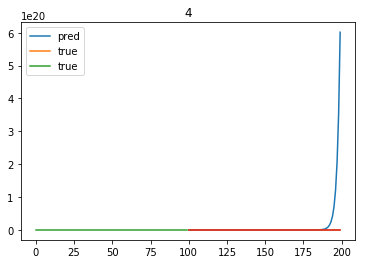

In [29]:
idx = np.random.randint(batch_size)
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), pred_outputs[idx].asnumpy().ravel(), label='pred')
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), predict_target[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), predict_input[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), exog_input[idx].asnumpy().ravel())
ax.set_title(idx)
ax.legend();

## Train TCN using entire prediction sequence

In [564]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
channel_list = [10]
train_sequences=True

tcn = TCN(channel_list, feature_dim, input_seq_len, output_seq_len, train_sequences=train_sequences)

# collect all NDArrays associated with each layer and initialize them
tcn.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.GenSequenceFullDataset(input_seq_len, output_seq_len, 
                                                 return_sequences=train_sequences, spacing=15, lam=0.3),
            'valid': data.GenSequenceFullDataset(input_seq_len, output_seq_len, 
                                                 return_sequences=train_sequences, spacing=15, lam=0.3)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=100, log_interval=20)

[Epoch 5] train loss = 73.343
[Epoch 5] valid loss = 63.089
[Epoch 10] train loss = 21.011
[Epoch 10] valid loss = 17.121
[Epoch 15] train loss = 8.249
[Epoch 15] valid loss = 7.354
[Epoch 20] train loss = 5.539
[Epoch 20] valid loss = 5.360
[Epoch 25] train loss = 4.960
[Epoch 25] valid loss = 4.761
[Epoch 30] train loss = 4.717
[Epoch 30] valid loss = 4.414
[Epoch 35] train loss = 4.335
[Epoch 35] valid loss = 4.190
[Epoch 40] train loss = 4.160
[Epoch 40] valid loss = 4.017
[Epoch 45] train loss = 4.107
[Epoch 45] valid loss = 3.896
[Epoch 50] train loss = 3.990
[Epoch 50] valid loss = 3.724


In [578]:
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': 0.001})
train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=50, log_interval=10)

[Epoch 10] train loss = 2.638
[Epoch 10] valid loss = 2.469
[Epoch 20] train loss = 2.075
[Epoch 20] valid loss = 1.983
[Epoch 30] train loss = 1.829
[Epoch 30] valid loss = 1.744
[Epoch 40] train loss = 1.664
[Epoch 40] valid loss = 1.564
[Epoch 50] train loss = 1.497
[Epoch 50] valid loss = 1.460


In [595]:
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': 0.001})
train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=50, log_interval=10)

[Epoch 10] train loss = 1.410
[Epoch 10] valid loss = 1.378
[Epoch 20] train loss = 1.315
[Epoch 20] valid loss = 1.307
[Epoch 30] train loss = 1.343
[Epoch 30] valid loss = 1.325
[Epoch 40] train loss = 1.332
[Epoch 40] valid loss = 1.325
[Epoch 50] train loss = 1.323
[Epoch 50] valid loss = 1.312


In [596]:
pred_steps = 300
pred_ds = data.GenSequenceFullDataset(input_seq_len, pred_steps, 
                                      return_sequences=train_sequences, spacing=15, lam=0.3)
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
predict_input, exog_input, predict_target = next(iter(loader))

In [597]:
pred_outputs = tcn.predict_dynamic(predict_input, pred_steps, exog_input=exog_input)

<IPython.core.display.Javascript object>


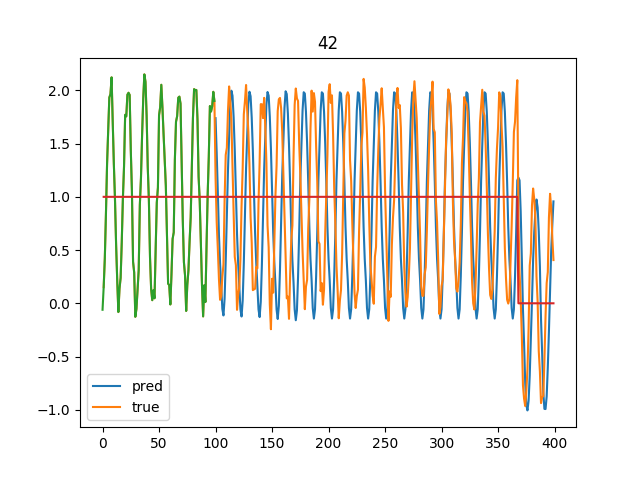

In [610]:
idx = np.random.randint(batch_size)
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), pred_outputs[idx].asnumpy().ravel(), label='pred')
ax.plot(np.arange(1, input_seq_len + pred_steps), predict_target[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), predict_input[idx].asnumpy().ravel())
ax.plot(np.arange(1, input_seq_len + pred_steps), exog_input[idx].asnumpy().ravel())
ax.set_title(idx)
ax.legend();